In [1]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from PIL import Image
from io import BytesIO
import tensorflow as tf
%matplotlib inline

# identify bucket
role = get_execution_role()
bucket='my-bucket'
# image size
imsize = 224
# batch size
bsize = 10

# change limit to 10,000 then load data from s3
client = boto3.client('s3')
paginator = client.get_paginator('list_objects')
page_iterator = paginator.paginate(Bucket=bucket, PaginationConfig={'MaxItems': 10000}, Prefix="data/test")

# count number of data
n = 0
files = []
for page in page_iterator:
    n += len(page['Contents'])
    for file in page['Contents']:
        files.append(file['Key'])
    
files = files[1:]
print("number of data:", n-1)
print(files[0:5])

number of data: 1707
['data/test/busy/20150708_1530_11.jpg', 'data/test/busy/20150708_1530_12.jpg', 'data/test/busy/20150708_1530_13.jpg', 'data/test/busy/20150708_1530_15.jpg', 'data/test/busy/20150708_1530_16.jpg']


In [2]:
from random import shuffle
shuffle(files)

## seperate to 100 each
file_batches = []
n = 0
file_batch = []
for file in files:
    file_batch.append(file)
    n += 1
    if n % 10 == 0:
        file_batches.append(file_batch)
        file_batch = []

file_batches.append(file_batch)
print(file_batch[0:10])

['data/test/busy/20150708_1540_27.jpg', 'data/test/free/20150708_1540_33.jpg', 'data/test/busy/20150708_1700_44.jpg', 'data/test/busy/20150708_1745_37.jpg', 'data/test/free/20150708_1805_3.jpg', 'data/test/free/20150708_1805_34.jpg', 'data/test/busy/20150708_1735_48.jpg']


In [15]:
# load trained model
model = tf.keras.models.load_model('trained_carpark_MobileNetV2.h5')

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 4, 4, 1280)        0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1280)        0         
_________________________________________________________________
dense (Dense)                (None, 4, 4, 1280)        1639680   
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 1280)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1280)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 2, 2, 640)         8

In [16]:
test_loss = []
test_acc = []
i = 0
sum_acc = 0
for file_batch in file_batches:

    label = []
    im = np.empty((1,imsize,imsize,3), int)
    ## for 1 batch
    print("This is batch number: " + str(i) + " out of " + str(len(file_batches)))
    
    # collect images and labels
    print("collecting data")
    for file in file_batch:
        if "busy" in file:
            label.append(1)
        else :
            label.append(0)
        # collect image
        img = Image.open(BytesIO(client.get_object(Bucket=bucket, Key=file)['Body'].read())).resize((imsize,imsize))
        im = np.append(im, ((np.asarray(img, dtype="int32")/127.5) - 1).reshape((1,imsize,imsize,3)), axis=0)
    im = im[1:]
    
    print("number of image:", len(label))


    X = tf.convert_to_tensor(im)
    y = tf.convert_to_tensor(label)

    loss, acc = model.evaluate(X, y, batch_size=10, steps=1)
    test_loss.append(loss)
    test_acc.append(acc)
    sum_acc += acc
    print('Restored model, accuracy: {:5.2f}%'.format(100*acc))
    
    i += 1
    
    if i == 20:
        break

This is batch number: 0 out of 171
collecting data
number of image: 10
1/1 [==============================] - 5s 5s/step - loss: 1.5333 - acc: 0.9000
Restored model, accuracy: 90.00%
This is batch number: 1 out of 171
collecting data
number of image: 10
1/1 [==============================] - 4s 4s/step - loss: 6.1333 - acc: 0.6000
Restored model, accuracy: 60.00%
This is batch number: 2 out of 171
collecting data
number of image: 10
1/1 [==============================] - 4s 4s/step - loss: 1.5333 - acc: 0.9000
Restored model, accuracy: 90.00%
This is batch number: 3 out of 171
collecting data
number of image: 10
1/1 [==============================] - 4s 4s/step - loss: 6.1333 - acc: 0.6000
Restored model, accuracy: 60.00%
This is batch number: 4 out of 171
collecting data
number of image: 10
1/1 [==============================] - 3s 3s/step - loss: 4.6000 - acc: 0.7000
Restored model, accuracy: 70.00%
This is batch number: 5 out of 171
collecting data
number of image: 10
1/1 [=========

average accuracy: 0.7449999988079071


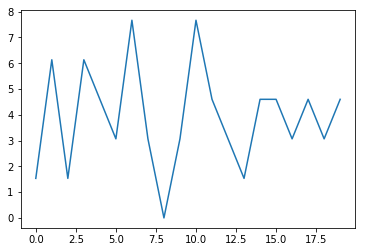

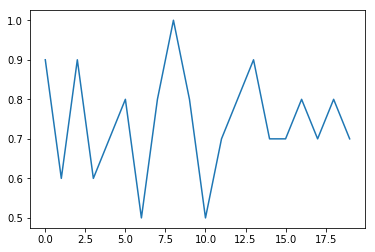

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

print("average accuracy:", sum_acc/i)

plt.plot(test_loss)
plt.show()
plt.plot(test_acc)
plt.show()

In [ ]:
### check query time for 5 image

In [ ]:
import time
start = time.time()
test_image = im[0]
test_label = label[0]
for i in range(5):
    print(model.predict(test_images))
print(test_label)
print(time.time() - start)